In [42]:
# Quick hack to fix local imports for the generated files
import os
import sys
module_path = os.path.abspath(os.path.join('../generated'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [43]:
import platform
import subprocess
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import OutbreakSim.Model.Model as gen_model
import OutbreakSim.Model.Vec2

In [44]:
def load_reports(report_dir):
    with open(report_dir + "parameters.json") as f:
        parameters = json.load(f)
    with open(report_dir + "concluding.json") as f:
        concluding = json.load(f)
        
    intermediary = pd.read_csv(report_dir + "intermediary.csv")
    
    return (parameters, intermediary, concluding)

In [45]:
def load_synthetic_environment(data_file_path):
    data_file_path = Path(data_file_path)
    if not data_file_path.exists() and platform.system() == 'Linux':
        # Try to convert the path to a WSL path
        data_file_path = Path(subprocess.run(['wslpath', '-a', data_file_path], capture_output=True).stdout.decode().strip())
    
    buf = open(data_file_path, 'rb').read()
    return gen_model.Model.GetRootAsModel(buf, 0)

In [46]:
def parse_reports(report_dir):
    parameters, intermediary, concluding = load_reports(report_dir)
    synth_env = load_synthetic_environment(concluding['synthetic_environment_path'])
    
    intermediary['day'] = intermediary['time_step'] / parameters['time_steps_per_day']
    intermediary = intermediary.set_index('day')
    intermediary.drop('time_step', axis='columns', inplace=True)
    intermediary.rename({
        'num_susceptible': 'Susceptible', 
        'num_presymptomatic': 'Pre-symptomatic', 
        'num_infected': 'Infected', 
        'num_recovered': 'Recovered'}, 
        axis='columns', inplace=True)
    
    return (synth_env, parameters, intermediary, concluding)

In [47]:
def calc_area(syth_env):
    bounds_min = synth_env.Bounds().Min(OutbreakSim.Model.Vec2.Vec2())
    bounds_max = synth_env.Bounds().Max(OutbreakSim.Model.Vec2.Vec2())
    
    return (bounds_max.X() - bounds_min.X()) * (bounds_max.Y() - bounds_min.Y())

def parse_end_stats(index_name, synth_env, parameters, concluding):    
    return pd.DataFrame.from_records([{
        'num_agents': synth_env.Agents().AgeLength(),
        'area': calc_area(synth_env),
        'total_exec_time': concluding['simulation_execution_time_in_secs'],
        'steps_per_day': parameters['time_steps_per_day'],
        'total_steps': concluding['total_time_steps'],
    }], index=[index_name])

In [48]:
def graph_infections(intermediary, title):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.set_ylabel('Number of People')
    ax.set_title(title)
    intermediary.plot(ax=ax)
    return fig

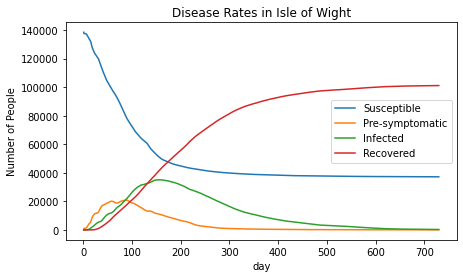

In [50]:
synth_env, parameters, intermediary, concluding = parse_reports("../../reports/isle_of_wight/0/")
fig = graph_infections(intermediary, 'Disease Rates in Isle of Wight')
fig.savefig('graphs/isle_of_wight')
stats = parse_end_stats('isle_of_wight', synth_env, parameters, concluding)

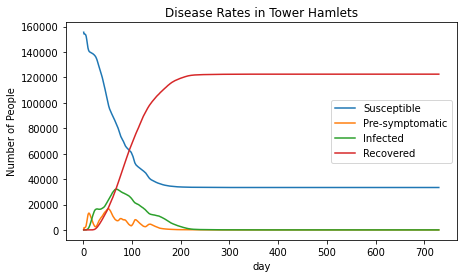

In [51]:
synth_env, parameters, intermediary, concluding = parse_reports("../../reports/tower_hamlets/0/")
fig = graph_infections(intermediary, 'Disease Rates in Tower Hamlets')
fig.savefig('graphs/tower_hamlets')
stats = stats.append(parse_end_stats('tower_hamlets', synth_env, parameters, concluding))

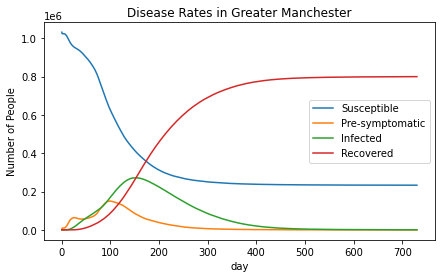

In [52]:
synth_env, parameters, intermediary, concluding = parse_reports("../../reports/greater_manchester/0/")
fig = graph_infections(intermediary, 'Disease Rates in Greater Manchester')
fig.savefig('graphs/greater_manchester')
stats = stats.append(parse_end_stats('greater_manchester', synth_env, parameters, concluding))

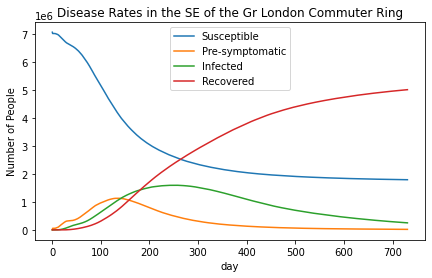

In [53]:
synth_env, parameters, intermediary, concluding = parse_reports("../../reports/london_se_commuter_ring/0/")
fig = graph_infections(intermediary, 'Disease Rates in the SE of the Gr London Commuter Ring')
fig.savefig('graphs/london_se_commuter_ring')
stats = stats.append(parse_end_stats('london_se_commuter_ring', synth_env, parameters, concluding))

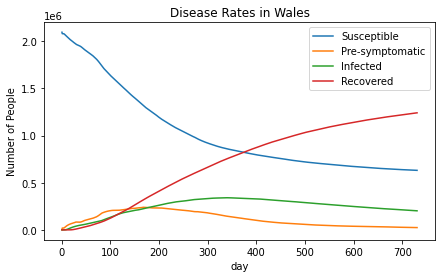

In [54]:
synth_env, parameters, intermediary, concluding = parse_reports("../../reports/wales/0/")
fig = graph_infections(intermediary, 'Disease Rates in Wales')
fig.savefig('graphs/wales')
stats = stats.append(parse_end_stats('wales', synth_env, parameters, concluding))

In [55]:
stats['exec_time_per_step'] = stats['total_exec_time'] / stats['total_steps']
stats['pop_density'] = stats['area'] / stats['num_agents']

In [56]:
stats

,num_agents,area,total_exec_time,steps_per_day,total_steps,exec_time_per_step,pop_density
isle_of_wight,138644,8.325596e+08,19.462778,48,35040,0.000555,6005.017297
tower_hamlets,155942,1.663290e+07,23.093997,48,35040,0.000659,106.660835
greater_manchester,1033229,3.112930e+08,102.877001,48,35040,0.002936,301.281727
london_se_commuter_ring,7088145,2.901714e+09,663.425685,48,35040,0.018933,409.375693
wales,2099225,5.781438e+10,201.053761,48,35040,0.005738,27540.820655


<AxesSubplot:xlabel='exec_time_per_step', ylabel='num_agents'>

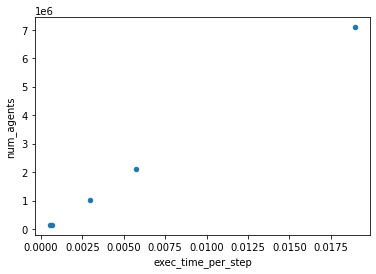

In [57]:
stats[['num_agents', 'exec_time_per_step']].plot(x='exec_time_per_step', y='num_agents', kind='scatter')

In [58]:
stats['total_exec_time'] / stats['num_agents']

isle_of_wight              0.000140
tower_hamlets              0.000148
greater_manchester         0.000100
london_se_commuter_ring    0.000094
wales                      0.000096
dtype: float64

<AxesSubplot:xlabel='exec_time_per_step', ylabel='pop_density'>

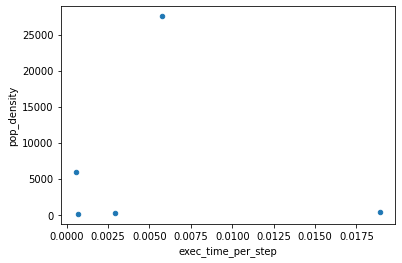

In [59]:
stats[['pop_density', 'exec_time_per_step']].plot(x='exec_time_per_step', y='pop_density', kind='scatter')